In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from celluloid import Camera

Matplotlib is building the font cache; this may take a moment.


In [2]:
# Get data from WHO: https://www.who.int/data/gho/data/indicators/indicator-details/GHO/gho-tobacco-control-monitor-current-tobaccouse-tobaccosmoking-cigarrettesmoking-agestd-tobagestdcurr
tobacco_use_full = pd.read_csv('./TobaccoUseData.csv')
tobacco_use_full.head(1)

,IndicatorCode,Indicator,ValueType,ParentLocationCode,ParentLocation,Location type,SpatialDimValueCode,Location,Period type,Period,...,FactValueUoM,FactValueNumericLowPrefix,FactValueNumericLow,FactValueNumericHighPrefix,FactValueNumericHigh,Value,FactValueTranslationID,FactComments,Language,DateModified
0,M_Est_tob_curr_std,Estimate of current tobacco use prevalence (%)...,numeric,SEAR,South-East Asia,Country,PRK,Democratic People's Republic of Korea,Year,2025,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Projected from surveys completed prior to 2020...,EN,2022-01-16T23:00:00.000Z


In [3]:
tobacco_use = tobacco_use_full[['Period', 'ParentLocation', 'Location type', 'Location', 'Value']]
tobacco_use.head(3)

,Period,ParentLocation,Location type,Location,Value
0,2025,South-East Asia,Country,Democratic People's Republic of Korea,0.0
1,2025,Europe,Country,Azerbaijan,0.1
2,2025,Africa,Country,Eritrea,0.2


In [4]:
# 2020 is the last real data point as the last update on this data set is 2022/01/17 and it doesn't feature 2021
tobacco_use_2020 = tobacco_use[tobacco_use['Period'] == 2020]
tobacco_use_2020_per_continent_summary = tobacco_use_2020.groupby('ParentLocation')['Value'].agg([np.mean, np.std])
tobacco_use_2020_per_continent_summary

,mean,std
ParentLocation,,
Africa,10.104201,8.893918
Americas,12.115046,7.437227
Eastern Mediterranean,16.654710,13.498557
Europe,24.888322,10.690888
South-East Asia,22.603889,18.665660
Western Pacific,23.805333,14.342116


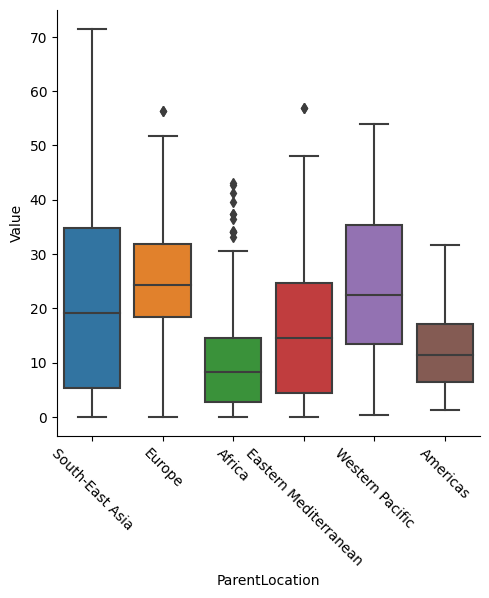

In [5]:
sns.catplot(x='ParentLocation', y='Value', data=tobacco_use_2020, kind='box')
plt.xticks(rotation=-45)
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


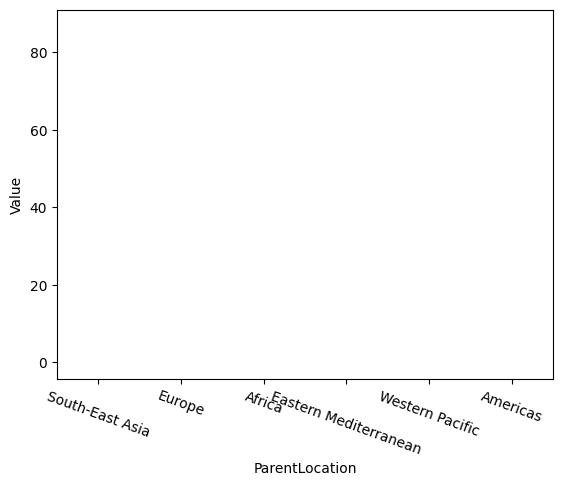

In [6]:
# Year by year evolution of smoking for each continent
tobacco_use_by_year = tobacco_use.groupby('Period')[['ParentLocation', 'Value']]

fig = plt.figure()
camera = Camera(figure=fig)

for year, year_data in tobacco_use_by_year:
    plt.xticks(rotation=-20)
    plot = sns.boxplot(x='ParentLocation', y='Value', data=year_data, ax=plt.gca())
    camera.snap()

animation = camera.animate(blit=False)
animation.save('animation.gif')


We can see that in the future the americas have a more drastic decrease tobacco consumption than any other continent following the general trend.
It's also important to note that the western pacific have a drastic increase in tobacco consumption.

Lets define two hypotheses to prove that tobacco consumption in the future (data points from 2023 to 2025) is lower:

H0: Tobacco consumption is the same for 2020 and for 2025
HA: Tobacco consumption is lower in 2025

(This types of hypotheses is perfect for proportion-ttest tests)

or more technically the hypotheses would be:

H0: pico2020 - pico2025 = 0
HA: pico2020 - pico2025 > 0

Lets define an alpha value of .02 to get a 98% confidence

In [7]:
from pingouin import ttest

In [8]:
alpha = .02

In [31]:
tobacco_use_2025 = tobacco_use[tobacco_use['Period'] == 2025]

ttest_result = ttest(x=tobacco_use_2025['Value'], y=tobacco_use_2020['Value'], alternative='less')
p = float(ttest_result['p-val'].values[0])

print(f'p-value: {p}')
print('Is the true the hypotheses which states that the tobacco consumption in 2025 is lower than in 2020? ' + str(p <= alpha))

p-value: 0.23856241809553302
Is the true the hypotheses which states that the tobacco consumption in 2025 is lower than in 2020? False


In [33]:
print(f'That states that in 2025 the results conclude that there will be less tobacco consumption in 2025 with a {(1 - p) * 100}% of confidence.')

That states that in 2025 the results conclude that there will be less tobacco consumption in 2025 with a 76.1437581904467% of confidence


By the animation that we saw before we can gather biases for the global trend, like continents that don't follow it. In this case the western pacific.

I'll filter out the western pacific to see how that affects the result:

In [35]:
tobacco_use_2025_no_western_pacific = tobacco_use_2025[tobacco_use_2025['ParentLocation'] != 'Western Pacific']
tobacco_use_2020_no_western_pacific = tobacco_use_2020[tobacco_use_2020['ParentLocation'] != 'Western Pacific']

Now I'll do the same as before but with the western pacific filtered out to search for sub-trends

In [36]:
ttest_result = ttest(x=tobacco_use_2025_no_western_pacific['Value'], y=tobacco_use_2020_no_western_pacific['Value'], alternative='less')
p = float(ttest_result['p-val'].values[0])

print(f'p-value: {p}')
print('Is the true the hypotheses which states that the tobacco consumption excluding the western pacific in 2025 is lower than in 2020? ' + str(p <= alpha))

p-value: 0.25732575054345136
Is the true the hypotheses which states that the tobacco consumption excluding the western pacific in 2025 is lower than in 2020? False


In [37]:
print(f'That states that in 2025, excluding the western pacific, the results conclude that there will be less tobacco consumption in 2025 with a {(1 - p) * 100}% of confidence.')

That states that in 2025, excluding the western pacific, the results conclude that there will be less tobacco consumption in 2025 with a 74.26742494565485% of confidence.


It turns out that the western pacific is included in the trend which states: the amount of tobacco consumed / smoked will decrease as time passes 